## Setup

In [342]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates

GOLD_PATH = '/home/lucas-nunes/workspace/Postech/challenges/2_ibov/data/gold'

MIN_THRESHOLD_VALID = 0.70 # Value should be at least this value to be considered on the Model

LIST_COLUMNS_DF_FILTER = ['data', 'ultimo']

## Read

In [343]:
df = pd.read_parquet(f'{GOLD_PATH}/gold.parquet')
list_value_columns = df.columns.to_list()
list_value_columns.remove('data')
list_value_columns.remove('ibov')
list_value_columns.remove('ibov_futuro')
list_value_columns.insert(len(list_value_columns), 'ibov_futuro')
list_value_columns.insert(len(list_value_columns), 'ibov')
list_value_columns

['prata',
 'us30',
 'ouro',
 'spx',
 'ndx',
 'petroleo',
 'vix',
 'eur_brl',
 'usd_brl',
 'ibrx100',
 'BBSA3',
 'CPLE6',
 'ITUB4',
 'VALE3',
 'PETR3',
 'ELET3',
 'ibrx50',
 'FTXIN9',
 'RENT3',
 'us500',
 'SLCE3',
 'cobre',
 'FLRY3',
 'bitcoin',
 'ferro',
 'MGLU3',
 'STOXX50E',
 'ethereum',
 'CRFB3',
 'ibov_futuro',
 'ibov']

## Correlations

In [344]:
df_2k = df.where(df['data'] > datetime.date(2000, 1, 1)).dropna(how='all')

In [345]:
correlation_matrix = df[list_value_columns].corr()
correlation_matrix_only_ibov = df[list_value_columns].corr()[['ibov']].sort_values(by='ibov')
correlation_matrix_2k = df_2k[list_value_columns].corr()

In [346]:
list_index_within_threshold = [key for key, value in correlation_matrix['ibov'].to_dict().items() if value > MIN_THRESHOLD_VALID]

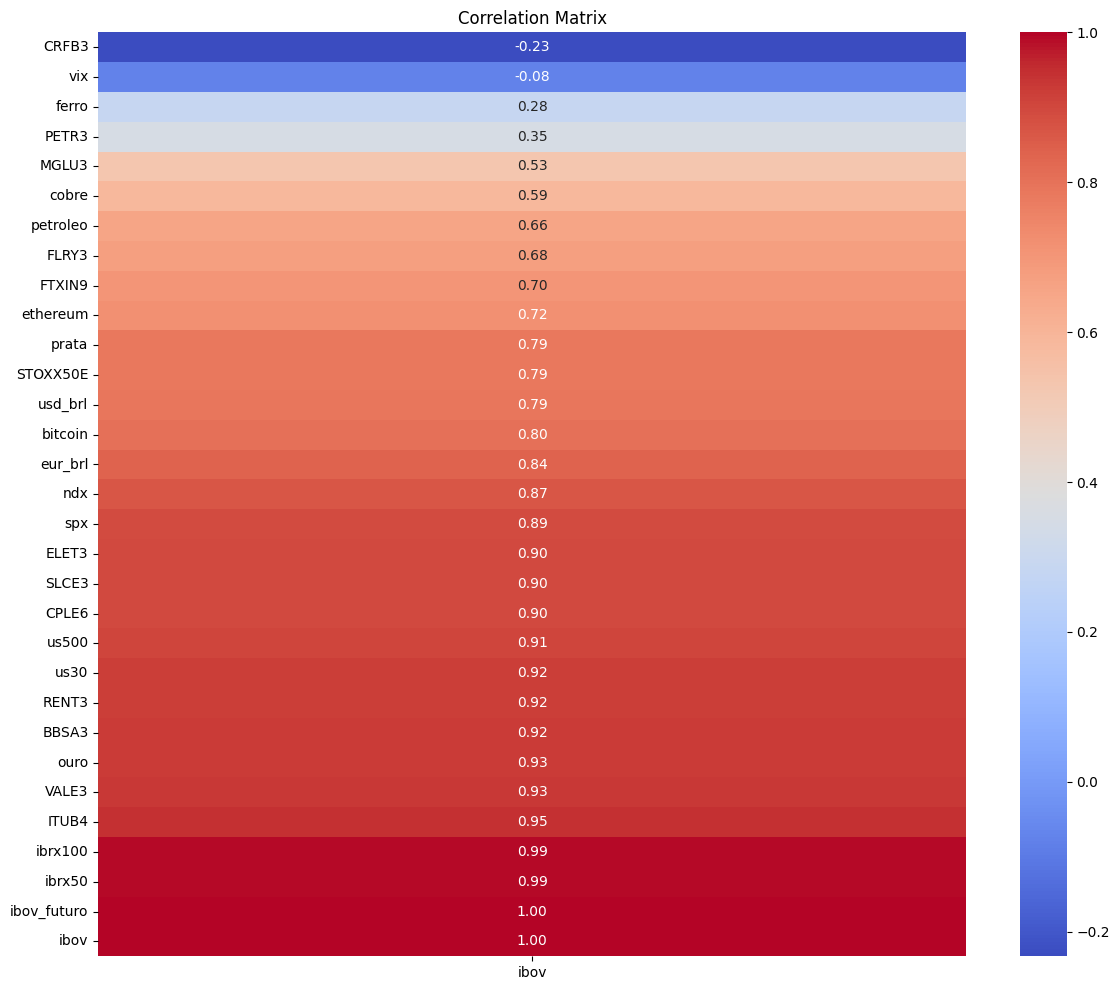

In [347]:
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_only_ibov, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

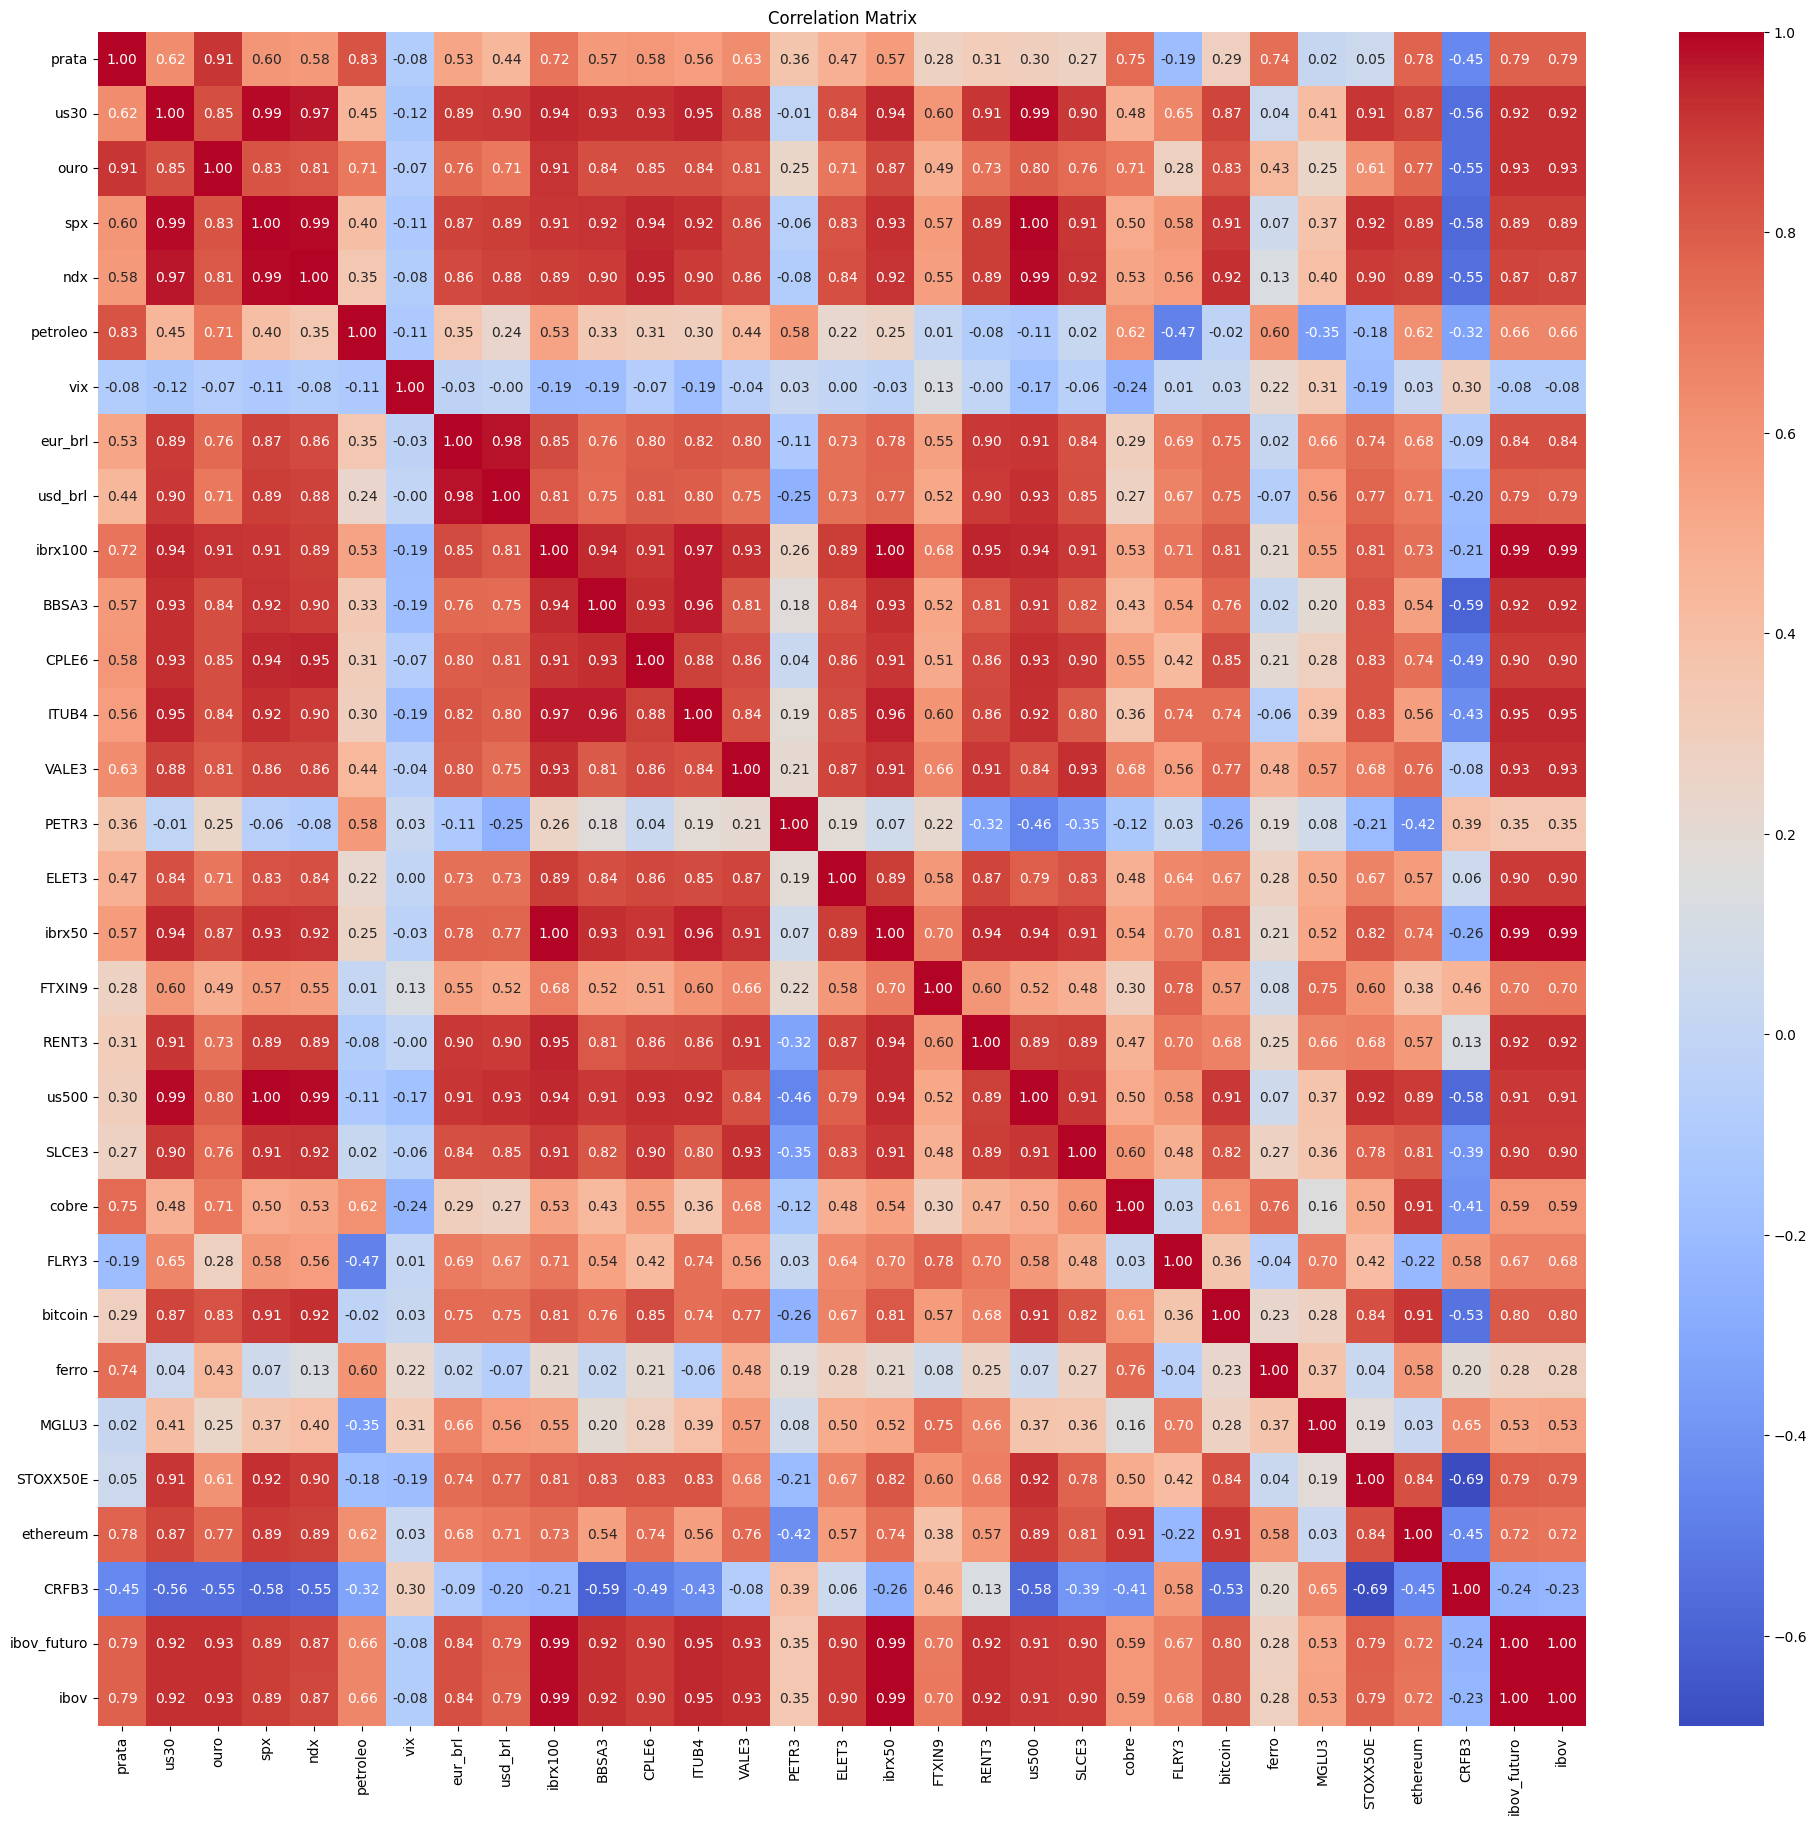

In [348]:
plt.figure(figsize=(24, 22))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

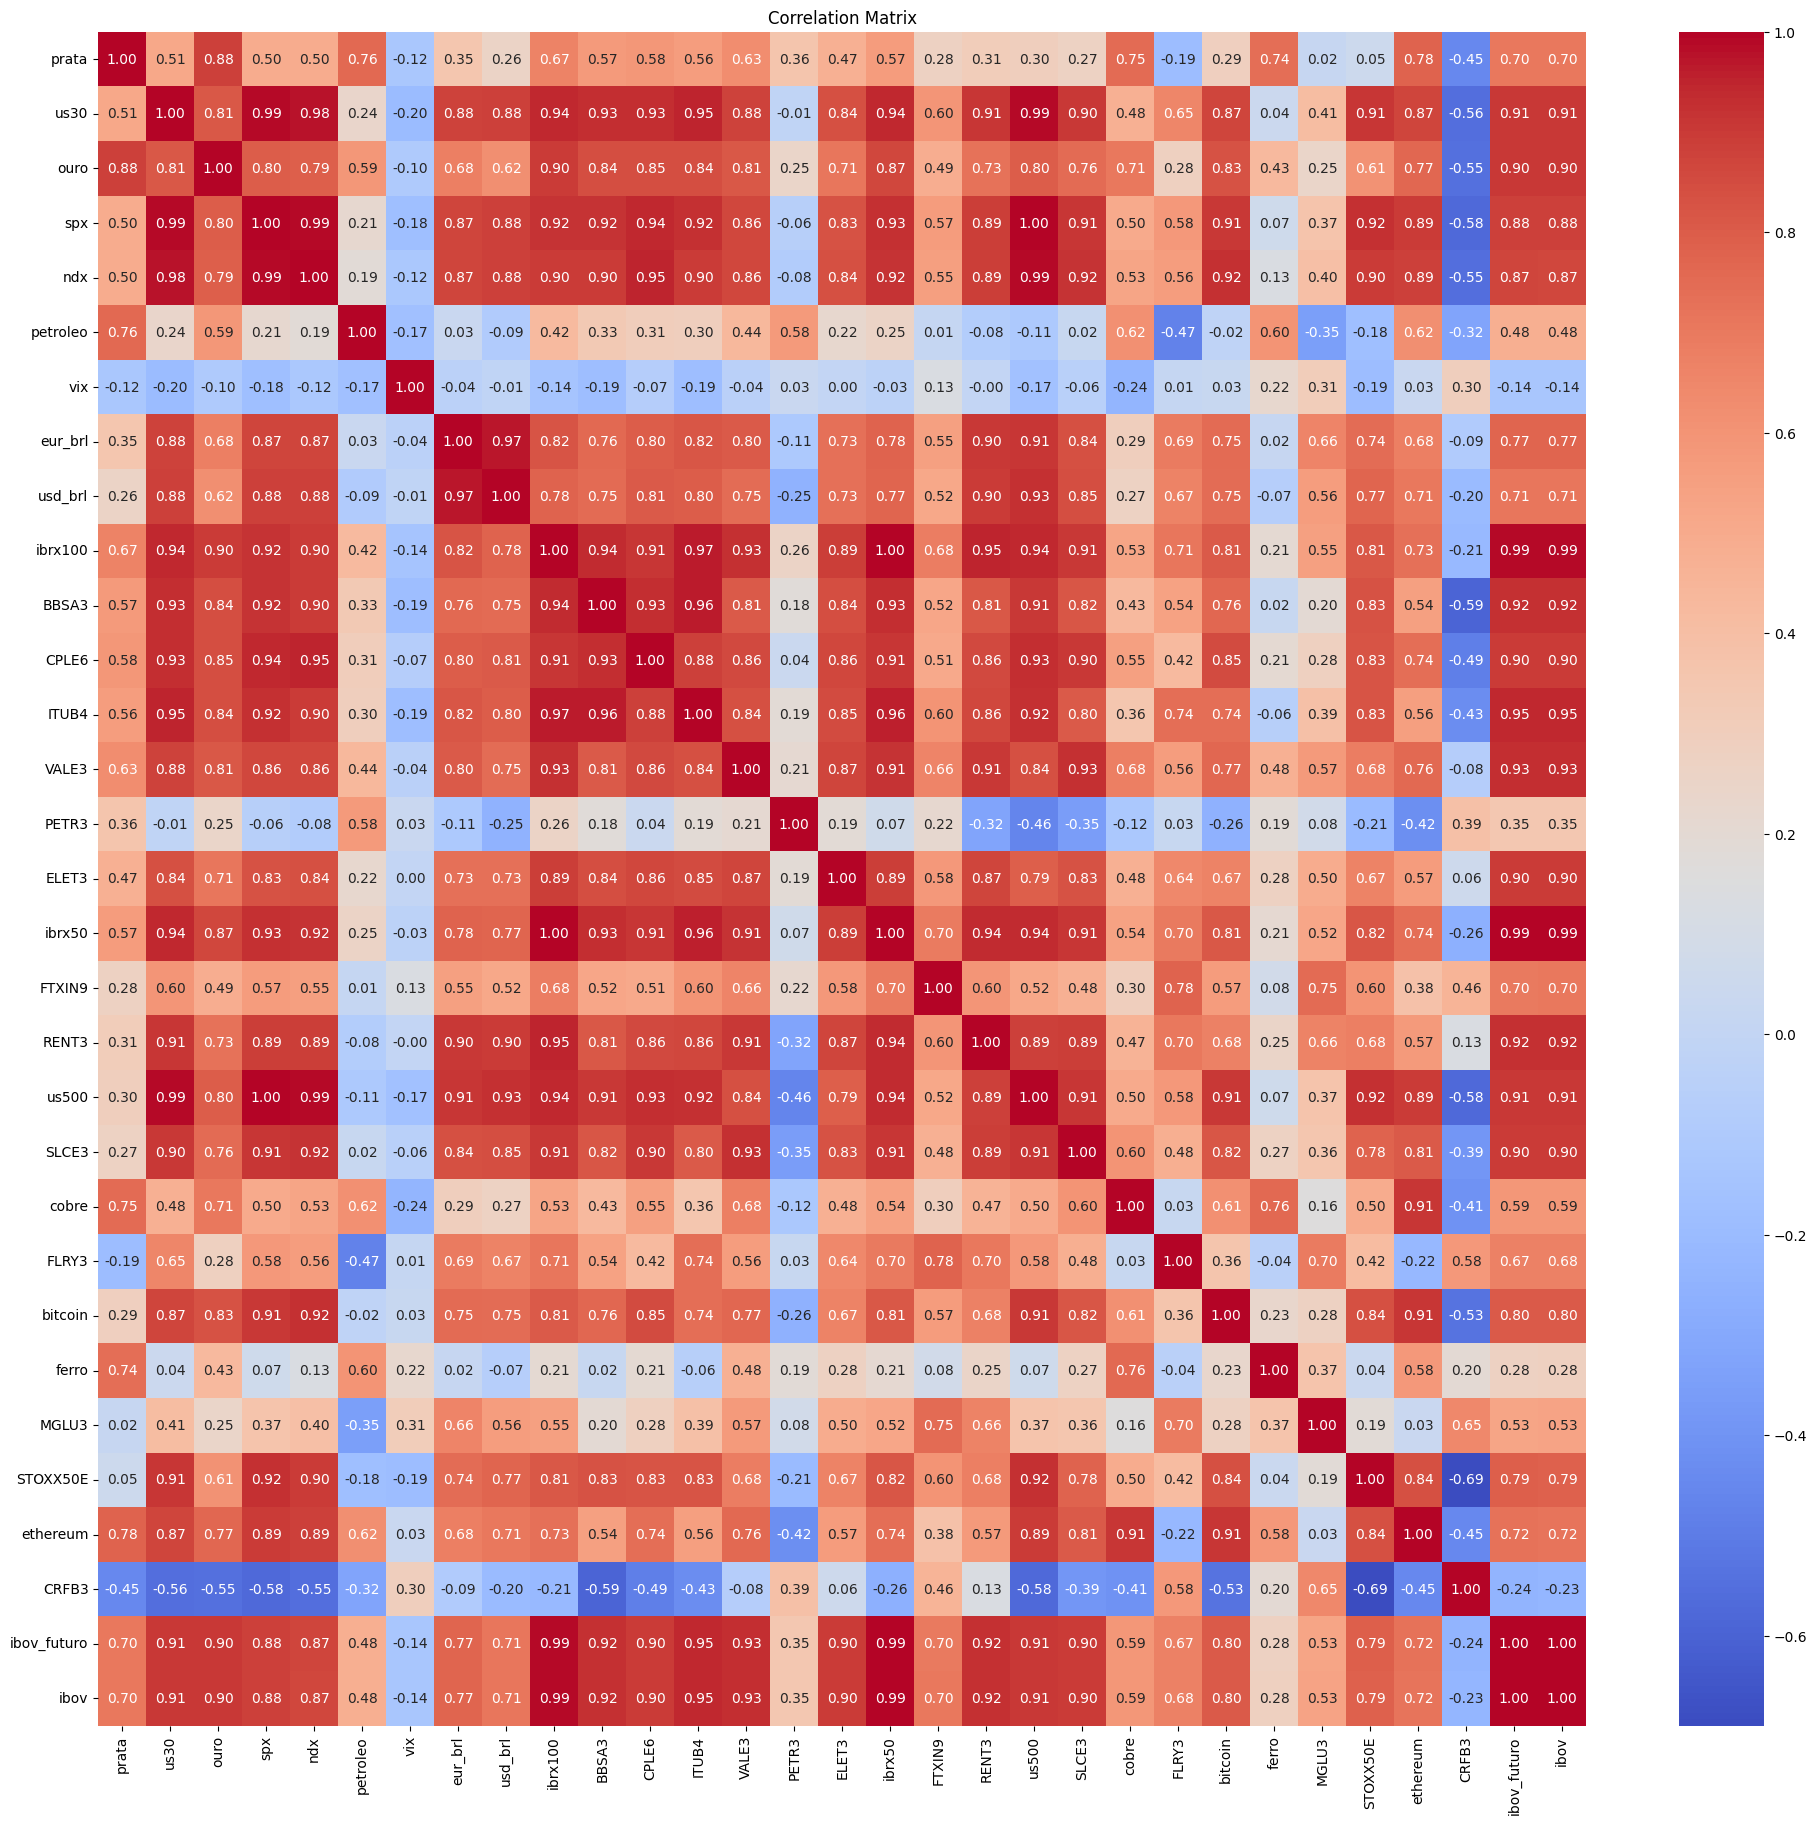

In [349]:
plt.figure(figsize=(24, 22))
sns.heatmap(correlation_matrix_2k, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Timeseries Forecast Model


In [350]:
df_training = df.where(df['data'] <= datetime.date(2025,1,1)).dropna(how='all')
# Set 'data' column as index
df_training.set_index('data', inplace=True)

# Select the column to forecast, for example 'ultimo'
ts = df_training['ibov']

# Fit ARIMA model
model = ARIMA(ts, order=(5, 1, 0))  # (p, d, q) order of the model
model_fit = model.fit()

# Forecast
forecast_steps = 45
forecast = model_fit.forecast(steps=forecast_steps)

# Create a new datetime index for the forecast steps
forecast_dates = pd.date_range(start=ts.index[-1], periods=forecast_steps)

# Combine the forecast dates with the forecast values
forecast_series = pd.Series(forecast.values, index=forecast_dates)


# Print the forecast with datetime index
print(forecast_series)

/home/lucas-nunes/workspace/Postech/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lucas-nunes/workspace/Postech/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/lucas-nunes/workspace/Postech/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2025-01-01    120282.892983
2025-01-02    120282.957206
2025-01-03    120282.850504
2025-01-04    120282.857380
2025-01-05    120282.856515
2025-01-06    120282.858407
2025-01-07    120282.857330
2025-01-08    120282.858209
2025-01-09    120282.858092
2025-01-10    120282.858118
2025-01-11    120282.858092
2025-01-12    120282.858106
2025-01-13    120282.858098
2025-01-14    120282.858099
2025-01-15    120282.858099
2025-01-16    120282.858099
2025-01-17    120282.858099
2025-01-18    120282.858099
2025-01-19    120282.858099
2025-01-20    120282.858099
2025-01-21    120282.858099
2025-01-22    120282.858099
2025-01-23    120282.858099
2025-01-24    120282.858099
2025-01-25    120282.858099
2025-01-26    120282.858099
2025-01-27    120282.858099
2025-01-28    120282.858099
2025-01-29    120282.858099
2025-01-30    120282.858099
2025-01-31    120282.858099
2025-02-01    120282.858099
2025-02-02    120282.858099
2025-02-03    120282.858099
2025-02-04    120282.858099
2025-02-05    120282

In [351]:
df_test = df.where(df['data'] >= datetime.date(2025,1,1)).dropna(how='all')
df_test = df_test[['data', 'ibov']]

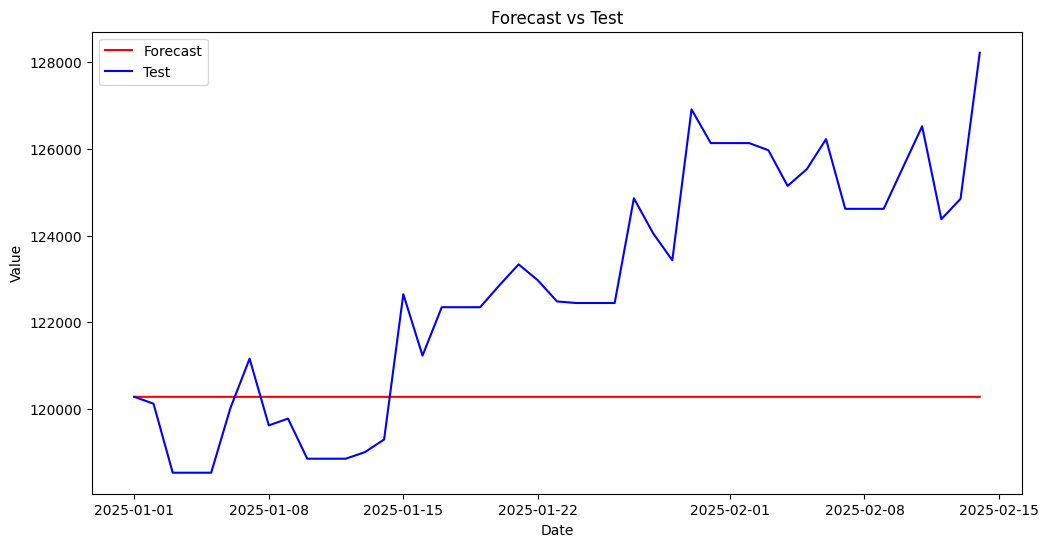

In [352]:
# Plot the comparison between forecast_series and df_test
plt.figure(figsize=(12, 6))
plt.plot(forecast_series, label='Forecast', color='red')
plt.plot(df_test['data'], df_test['ibov'], label='Test', color='blue')
plt.title('Forecast vs Test')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

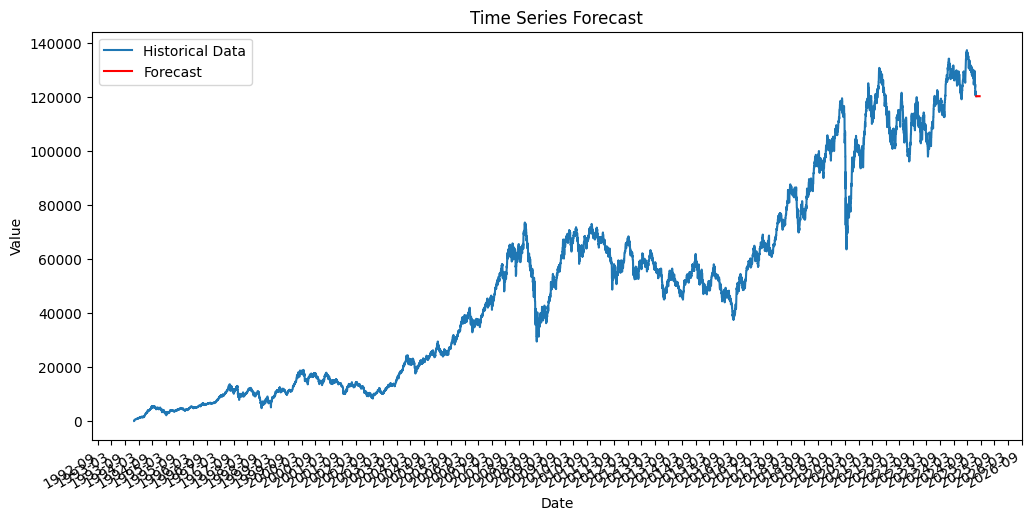

In [353]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Historical Data')
plt.plot(forecast, label='Forecast', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()
plt.title('Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [354]:
ts = df_test['ibov']

In [355]:
df_forecast = pd.DataFrame({'forecast': forecast_series}).reset_index().rename(columns={'index': 'data'})

df_forecast['data'] = df_forecast['data'].apply(lambda x: x.date())
df_forecast = df_forecast.merge(right=df_test)
df_forecast['diff'] = df_forecast['ibov'] - df_forecast['forecast']
df_forecast['diff_perc'] = abs(df_forecast['ibov'] - df_forecast['forecast'])/df_forecast['ibov']
df_forecast['precision'] = 1 - df_forecast['diff_perc']

In [361]:
df_forecast['precision'].mean()
df_forecast['precision'].median()

np.float64(0.9807000252656553)

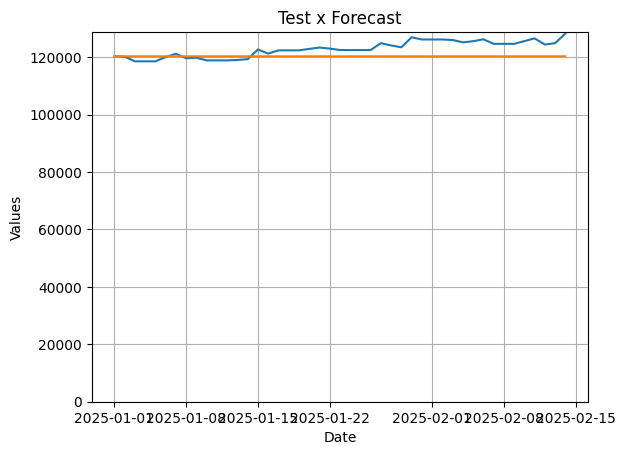

<Figure size 1200x600 with 0 Axes>

In [357]:

fig, ax = plt.subplots()

plt.figure(figsize=(12, 6))

ax.plot(df_forecast['data'], df_forecast['ibov'], label='Value')
ax.plot(df_forecast['data'], df_forecast['forecast'], label='Forecast')

ax.grid()
ax.set(
    xlabel='Date', 
    ylabel='Values',
    title='Test x Forecast'
)

ax.set_ylim(ymin=0)

plt.show()


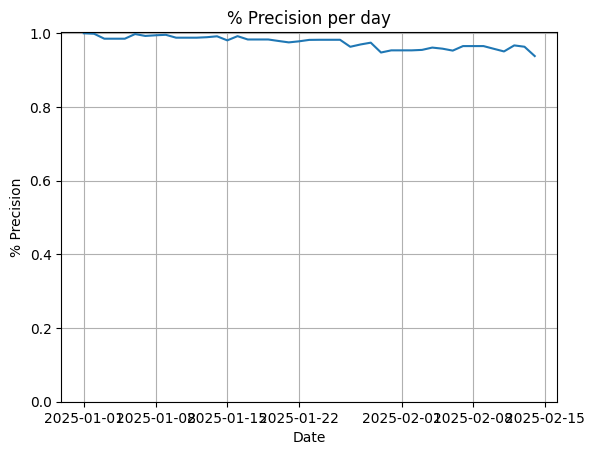

<Figure size 1200x600 with 0 Axes>

In [358]:
df_precision = df_forecast[['data', 'precision']]

fig, ax = plt.subplots()

plt.figure(figsize=(12, 6))

ax.plot(df_precision['data'], df_precision['precision'], label='a')
ax.set_ylim(ymin=0)
ax.grid()
ax.set(
    xlabel='Date', 
    ylabel='% Precision',
    title='% Precision per day'
)

plt.show()

In [359]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and MSE
mae = mean_absolute_error(ts[-forecast_steps:], forecast)
mse = mean_squared_error(ts[-forecast_steps:], forecast)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

Mean Absolute Error (MAE): 3096.6007875627215
Mean Squared Error (MSE): 13677516.45517158
